In [69]:
%run ../../DataFiles_and_Notebooks/talktools.py

<Figure size 432x288 with 0 Axes>

<img src="https://jax.readthedocs.io/en/latest/_static/jax_logo_250px.png">

Jax is accelerated numpy (and more): https://jax.readthedocs.io/en/latest/jax-101/01-jax-basics.html


- JAX provides a NumPy-inspired interface for convenience.

- Through duck-typing, JAX arrays can often be used as drop-in replacements of NumPy arrays.

- Unlike NumPy arrays, JAX arrays are always immutable.

Python code can be converted to highly efficient compiled code in real-time, using XLA (Accelerated Linear Algebra). Note not all JAX code can be JIT compiled, as it requires array shapes to be static & known at compile time.

In [1]:
import jax
import jax.numpy as jnp

In [10]:
jnp.int32, jnp.float64

(jax._src.numpy.lax_numpy.int32, jax._src.numpy.lax_numpy.float64)

In [11]:
x = jnp.arange(10)
print(x)

[0 1 2 3 4 5 6 7 8 9]


In [12]:
type(x)

jaxlib.xla_extension.DeviceArray

In [13]:
n_devices = jax.local_device_count() 
n_devices

1

JAX uses the XLA compiler under the hood, and enables you to just-in-time (jit) compile your code to make it faster and more efficient. This is the purpose of the @jit annotation. 

In [15]:
from jax import jit

@jit
def bar(a, b, c):
    return a + b  * c

@jit
def foo(a, b, c):
    return a + b  * c

print(foo)
print(foo(1, 2, 3))

<CompiledFunction of <function foo at 0x1250160d0>>
7


In [17]:
a = jnp.sqrt((1+2j).real**2 + (1+2j).imag**2)

foo(2,a,0j)

DeviceArray(2.+0.j, dtype=complex64, weak_type=True)

In [20]:
@jit
def square(x):
    return x ** 2

@jit
def hypot(x, y):
    return jnp.sqrt(square(x) + square(y))

In [21]:
hypot(4,5)

DeviceArray(6.4031243, dtype=float32)

In [23]:
@jit
def f2(x, y):
    return x + y

print(f2(1, 2))
print(f2("a", "b"))

3


TypeError: Argument 'a' of type <class 'str'> is not a valid JAX type.

In [39]:
def na_var(data):
    sample_mean = 0.0
    
    # 1st loop
    for x in data:
        sample_mean =  sample_mean + x
    
    sample_mean = sample_mean / len(data)
    
    # second loop
    sum_of_squared_errors = 0.0
    for x in data:
        sum_of_squared_errors += (x - sample_mean) ** 2
    
    ret =  sum_of_squared_errors / (len(data) - 1.0)
    return ret

In [41]:
import numpy as np
%timeit na_var(np.arange(1000))

3.5 ms ± 159 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
jax_na_var = jit(na_var)

In [43]:
%timeit jax_na_var(jnp.arange(1000))

The slowest run took 23.48 times longer than the fastest. This could mean that an intermediate result is being cached.
484 µs ± 727 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [44]:
from jax import numpy as jnp, random

def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

v = random.normal(random.PRNGKey(42), (1000000,))
%timeit selu(v).block_until_ready()

3.24 ms ± 153 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
import jax

selu_jit = jax.jit(selu)
%timeit selu_jit(v).block_until_ready()

775 µs ± 65.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [46]:
long_vector = jnp.arange(int(1e7))

%timeit jnp.dot(long_vector, long_vector).block_until_ready()

6.35 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
def filter2d(image, filt):
    M, N = image.shape
    Mf, Nf = filt.shape
    Mf2 = Mf // 2
    Nf2 = Nf // 2
    result = jnp.zeros_like(image)
    for i in range(Mf2, M - Mf2):
        for j in range(Nf2, N - Nf2):
            num = 0.0
            for ii in range(Mf):
                for jj in range(Nf):
                    num += (filt[Mf-1-ii, Nf-1-jj] * image[i-Mf2+ii, j-Nf2+jj])
            # result[i, j] = num
            result = result.at[i, j].set(num)
    return result

### JAX Gotchas

Looping and flow control (e.g. if..then statements) are non-trivial in JAX. You cannot simply `@jit` any python function. See:

https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.fori_loop.html


## Numba  ##

LLVM compiler for python (brought to you by Continuum). Should be on everyone's conda installation already. But you might want to update (it's been changed recently):

   `conda update numba`

Docs: http://numba.pydata.org/numba-doc/0.54.1/index.html

In [61]:
import numba
numba.__version__

'0.54.1'

In [62]:
import numpy

def filter2d(image, filt):
    M, N = image.shape
    Mf, Nf = filt.shape
    Mf2 = Mf // 2
    Nf2 = Nf // 2
    result = numpy.zeros_like(image)
    for i in range(Mf2, M - Mf2):
        for j in range(Nf2, N - Nf2):
            num = 0.0
            for ii in range(Mf):
                for jj in range(Nf):
                    num += (filt[Mf-1-ii, Nf-1-jj] * image[i-Mf2+ii, j-Nf2+jj])
            result[i, j] = num
    return result

In [63]:
from numba import double, jit

numbafilter_2d = jit(double[:,:](double[:,:], double[:,:]))(filter2d)

# Now numbafilter_2d runs at speeds as if you had first translated
# it to C, compiled the code and wrapped it with Python
image = numpy.random.random((100, 100))
filt = numpy.random.random((10, 10))
res = numbafilter_2d(image, filt)

In [64]:
%timeit numbafilter_2d(image, filt)

2.92 ms ± 395 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
%timeit filter2d(image, filt)

830 ms ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [66]:
%matplotlib inline
import matplotlib.pyplot as plt

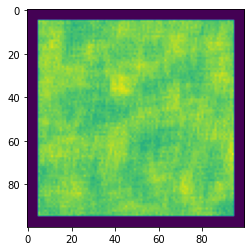

In [67]:
plt.imshow(res)

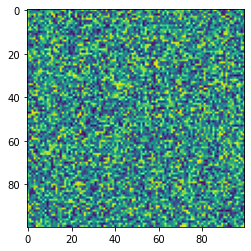

In [68]:
plt.imshow(image)

Numba also works with GPUs (and JAX with with GPU and TPUs).

```python
try:
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
except:
    pass
```

# Breakout

a. Write a nested for loop that does dot produce multiplication (on `A` and `B`, 2D arrays) and prints the results. 

In [71]:
import numpy as np

def my_dot(A, B):
    assert len(A.shape) == 2
    assert len(B.shape) == 2
    assert A.shape[1] == B.shape[0]
    
    outarray = np.zeros((A.shape[0], B.shape[1]))
    for i in range(outarray.shape[0]):
        for j in range(outarray.shape[1]):
            for k in range(B.shape[0]):
                outarray[i,j]  += A[i,k]*B[k,j]
    
    return outarray

b. Get the runtime speed for A.shape = (30,50) and B.shape = (50,15)

In [72]:
A = np.ones((30,50))
B = np.ones((50,15))

rez = my_dot(A, B)

np.alltrue(A.dot(B) == rez)

True

In [73]:
%timeit my_dot(A, B)

12.5 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


c. Try using numba to make it faster.

In [74]:
from numba import double, jit

numbamy_dot = jit(my_dot)

In [75]:
%timeit numbamy_dot(A, B)

45.7 µs ± 19.2 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


d. How does the numba speed compare to the native matrix multiplication in numpy (`numpy.dot`)?

In [76]:
%timeit A.dot(B)

3.98 µs ± 302 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
